In [1]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, concatenate
from keras.layers import Dense, Input, LSTM, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.initializers import Constant
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
test = pd.read_csv('/home/soniya51/Kaggle/Disaster Tweets/test.csv')
train = pd.read_csv('/home/soniya51/Kaggle/Disaster Tweets/train.csv')
test["keyword"] = test["keyword"].fillna("U")

In [4]:
test.head(20)

,id,keyword,location,text
0,0,U,NaN,Just happened a terrible car crash
1,2,U,NaN,"Heard about #earthquake is different cities, s..."
2,3,U,NaN,"there is a forest fire at spot pond, geese are..."
3,9,U,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,U,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,U,NaN,We're shaking...It's an earthquake
6,21,U,NaN,They'd probably still show more life than Arse...
7,22,U,NaN,Hey! How are you?
8,27,U,NaN,What a nice hat?
9,29,U,NaN,Fuck off!


In [5]:
test.isnull().any()

id          False
keyword     False
location     True
text        False
dtype: bool

In [6]:
dist_keyword=train['keyword'].value_counts()
dist_keyword

fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [7]:
# dropping location column
train = train.drop(['location'],axis=1)
test = test.drop(['location'],axis=1)
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
bool_keyword = pd.isnull(train['keyword']) 
#dropping missing 'keyword' records from train data set
train = train.drop(train[bool_keyword].index,axis=0)
#Resetting the index after droping the missing records
train = train.reset_index(drop=True)

In [9]:
y = train["target"].values

In [10]:
print(len(train))
train.head()

7552


,id,keyword,text,target
0,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,52,ablaze,Crying out for more! Set me ablaze,0
4,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [11]:
# removing urls
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [12]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

In [13]:
# removing html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [14]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

In [15]:
#removing emojis
import emoji
try:
    uchr = unichr  # Python 2
    import sys
    if sys.maxunicode == 0xffff:
        # narrow build, define alternative unichr encoding to surrogate pairs
        # as unichr(sys.maxunicode + 1) fails.
        def uchr(codepoint):
            return (
                unichr(codepoint) if codepoint <= sys.maxunicode else
                unichr(codepoint - 0x010000 >> 10 | 0xD800) +
                unichr(codepoint & 0x3FF | 0xDC00)
            )
except NameError:
    uchr = chr  # Python 3

# Unicode 11.0 Emoji Component map (deemed safe to remove)
_removable_emoji_components = (
    (0x20E3, 0xFE0F),             # combining enclosing keycap, VARIATION SELECTOR-16
    range(0x1F1E6, 0x1F1FF + 1),  # regional indicator symbol letter a..regional indicator symbol letter z
    range(0x1F3FB, 0x1F3FF + 1),  # light skin tone..dark skin tone
    range(0x1F9B0, 0x1F9B3 + 1),  # red-haired..white-haired
    range(0xE0020, 0xE007F + 1),  # tag space..cancel tag
)
emoji_components = re.compile(u'({})'.format(u'|'.join([
    re.escape(uchr(c)) for r in _removable_emoji_components for c in r])),
    flags=re.UNICODE)

def remove_emoji(text, remove_components=False):
    cleaned = emoji.get_emoji_regexp().sub(u'', text)
    if remove_components:
        cleaned = emoji_components.sub(u'', cleaned)
    return cleaned

In [16]:
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [17]:
# removing punctuation
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [18]:
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [19]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [20]:
sentences_train = train["text"]
sentences_test = test["text"]
keywords_train = train["keyword"]
keywords_test = test["keyword"]
sentences_train[1]

'We always try to bring the heavy metal RT '

In [21]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences_train))
tokenized_train = tokenizer.texts_to_sequences(sentences_train)
tokenized_test = tokenizer.texts_to_sequences(sentences_test)
tokenized_train

[[6713, 2804, 1869, 601],
 [46, 263, 858, 4, 953, 1, 859, 1166, 100],
 [6714, 431, 6715, 787, 250, 601, 3, 1113],
 [1562, 35, 9, 52, 250, 26, 601],
 [10, 1683, 755, 151, 16, 1, 1058, 137, 239, 14, 22, 601],
 [6716,
  4481,
  2361,
  2079,
  29,
  179,
  3448,
  348,
  48,
  4482,
  28,
  7,
  2362,
  58,
  37,
  250,
  1,
  6717,
  601,
  18,
  1114],
 [4483, 1250, 3, 4484, 250, 601],
 [6718,
  6719,
  2363,
  349,
  113,
  788,
  250,
  601,
  2080,
  1448,
  646,
  315,
  5,
  1,
  551,
  4485,
  75,
  6720],
 [601, 9, 11, 821, 756],
 [264, 245, 35, 3449],
 [10, 1, 674, 173, 601, 6, 1343, 28, 173, 114, 627],
 [95,
  43,
  1003,
  90,
  6721,
  1,
  4486,
  315,
  1250,
  1,
  6722,
  647,
  6,
  601,
  552,
  4,
  6723,
  4487,
  9,
  954,
  519,
  5,
  69],
 [4488, 6724, 9, 601, 6725],
 [7, 913, 4, 250, 1251, 601, 13, 12, 6726, 28, 33, 12, 2081],
 [7, 2082, 110, 1684, 3, 1, 137, 409, 11, 91, 34, 3450, 6, 1685, 13],
 [59, 1, 702, 22, 350, 860, 5, 1686, 601, 3, 92, 861],
 [582, 1, 144

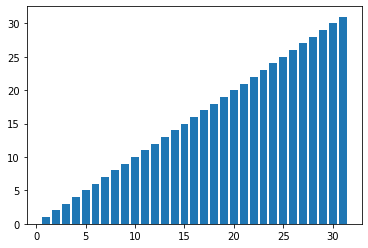

In [22]:
import matplotlib.pyplot as plt
data = []
for list1 in tokenized_train:
    data.append(len(list1))
plt.bar(data,data)
plt.show()

In [23]:
maxlen = 100
X_t = pad_sequences(tokenized_train, maxlen=maxlen)
X_te = pad_sequences(tokenized_test, maxlen=maxlen)


In [24]:
X_t

array([[   0,    0,    0, ..., 2804, 1869,  601],
       [   0,    0,    0, ...,  859, 1166,  100],
       [   0,    0,    0, ...,  601,    3, 1113],
       ...,
       [   0,    0,    0, ...,  364, 2066,  454],
       [   0,    0,    0, ..., 1606,    8,  364],
       [   0,    0,    0, ..., 2066,  454, 3256]], dtype=int32)

In [25]:
inp = Input(shape=(maxlen, ))

In [26]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/home/soniya51/Glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [27]:
word_index = tokenizer.word_index
print((word_index['name']))

767


In [28]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /home/soniya51/Glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [29]:
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [30]:
x = LSTM(60)(embedded_sequences)

In [31]:
keyword_inp = Input(shape=(1,), name='keyword_input')

In [32]:
x = concatenate([x, keyword_inp])

In [33]:
print (x.get_shape().as_list())

[None, 61]


In [34]:
x = Dropout(0.1)(x)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
x = Dense(50, activation="relu")(x)

In [36]:
x = Dropout(0.1)(x)

In [37]:
preds = Dense(1, activation="sigmoid")(x)

In [38]:
model = Model([inp, keyword_inp], outputs=preds)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
integer_mapping_t = {x: i for i,x in enumerate(keywords_train)}
integer_mapping_t['U'] = 0
keywords_x_train = [integer_mapping_t[word] for word in keywords_train]
keywords_x_test = [integer_mapping_t[word] for word in keywords_test]

In [40]:
keyword_x_train = np.asarray(keywords_x_train)
keyword_x_test = np.asarray(keywords_x_test)

In [41]:
if(set(keywords_test).issubset(set(keywords_train))): 
    flag = 1
flag

NameError: name 'flag' is not defined

In [42]:
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y, test_size=0.2)
k_train, k_cv = train_test_split(keyword_x_train, test_size=0.2)
X_cv.shape

(1511, 100)

In [43]:
batch_size = 32
epochs = 3
model.fit([np.array(X_train),np.array(k_train)],np.array(y_train), batch_size=batch_size, epochs=epochs, validation_split=0.1)



Train on 5436 samples, validate on 605 samples
Epoch 1/3
5436/5436 [==============================] - 15s 3ms/step - loss: 6.1933 - acc: 0.5633 - val_loss: 5.4848 - val_acc: 0.5835
Epoch 2/3
5436/5436 [==============================] - 14s 2ms/step - loss: 6.1578 - acc: 0.5843 - val_loss: 6.7102 - val_acc: 0.5719
Epoch 3/3
5436/5436 [==============================] - 14s 3ms/step - loss: 5.9311 - acc: 0.5951 - val_loss: 6.6584 - val_acc: 0.5785


In [44]:
y_cvPridected = model.predict([X_cv, k_cv], batch_size=batch_size, verbose=1)
#y_cvPridected = y_cvPridected.flatten()

1511/1511 [==============================] - 1s 895us/step


In [45]:

model.evaluate(y_cvPridected, y_cv, batch_size=batch_size, verbose=1)
print(y_cvPridected)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)]...

In [48]:
y_test = model.predict([X_te, keyword_x_test], batch_size=batch_size, verbose=1)
for i in range(len(y_test)):
    if(y_test[i]>=0.5):
        y_test[i] = 1
    else:
        y_test[i] = 0
y_test = y_test.astype(int)
y_test = y_test.flatten()
sample_submission = pd.read_csv("../soniya51/Downloads/sample_submission.csv")
print(sample_submission["target"].shape)
print(y_test.shape)
print(keyword_x_test.shape)
#y_test
sample_submission["target"] = y_test
sample_submission.to_csv('submission.csv', index=False)
results = pd.read_csv('submission.csv')

3263/3263 [==============================] - 2s 765us/step
(3263,)
(3263,)
(3263,)


In [ ]:
print(type(results["target"][0]))